In [15]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
np.set_printoptions(suppress=True)

from models import DeepConditionalModel
from inn_utils import train_online_ml, compute_metrics
from process_models import simulate_lotka_volterra, simulate_lv_params
from viz import (plot_true_est_scatter, 
                plot_true_est_posterior, 
                plot_losses, 
                plot_sbc, 
                plot_metrics, plot_variance)
import diagnostics as diag

In [2]:
tf.enable_eager_execution()

In [3]:
%load_ext autoreload
%autoreload 2

# Train with summary network

In [4]:
class SequenceNetwork(tf.keras.Model):
    """
    Implements an LSTM summary network to summarize time-series data generated from the Ricker model.
    """
    
    def __init__(self, h_lstm_dim=64, h_dense_dim=64):
        super(SequenceNetwork, self).__init__()
        
        self.summary_part = tf.keras.Sequential([
            tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(h_lstm_dim)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
            tf.keras.layers.Dense(h_dense_dim, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
            tf.keras.layers.Dense(h_dense_dim, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization()
        ])
    
    def call(self, x, training=True):
        
        x = self.summary_part(x, training=training)
        return x

In [54]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}


# --- Training hyperparameters --- #
train = False
param_names = [r'$\alpha$', r'$\beta$', r'$\delta$', r'$\gamma$']
theta_dim = 4
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
summary_dim = 9
epochs = 30
iterations_per_epoch = 1000
n_inv_blocks = 5
n_test = 500
n_sbc = 5000
n_samples_posterior = 2000
starter_learning_rate = 0.0005
decay_steps = 2000
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)
simulate_lotka_volterra = partial(simulate_lotka_volterra, n_points=500)

In [55]:
X_test, theta_test = simulate_lotka_volterra(n_test)
X_sbc, theta_sbc = simulate_lotka_volterra(n_sbc)

## Create networks

In [56]:
summary_net = SequenceNetwork(h_dense_dim=summary_dim)
model_sumnet = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [65]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model_sumnet)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/lv_sumnet', max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/lv_sumnet\ckpt-41


In [70]:
# %%time
# for ep in range(1, epochs+1):
#     with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
#         losses = train_online_ml(model_sumnet, optimizer, simulate_lotka_volterra, iterations_per_epoch, 
#                             batch_size, p_bar, clip_value=clip_value, 
#                             global_step=global_step)
        
#         plot_true_est_scatter(model_sumnet, X_test, theta_test, n_samples_posterior, param_names, figsize=(10, 3))
#         theta_samples = np.concatenate([model_sumnet.sample(x, n_samples=250, to_numpy=True)
#                                         for x in tf.split(X_sbc, 20, 0)], axis=0)
#         plot_sbc(theta_samples, theta_sbc, param_names, figsize=(10, 3), bins=25)
        
#         # Save model
#         manager.save()

# Train with summary stats

In [10]:
class NormalizationNetwork(tf.keras.Model):
    """
    Implements an LSTM summary network to summarize time-series data generated from the Ricker model.
    """
    
    def __init__(self):
        super(NormalizationNetwork, self).__init__()
        
        self.summary_part = tf.keras.layers.BatchNormalization()
        
    def call(self, x, training=True):
        
        x = self.summary_part(x, training=training)
        return x

In [11]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}


# --- Training hyperparameters --- #
train = False
param_names = [r'$\alpha$', r'$\beta$', r'$\delta$', r'$\gamma$']
theta_dim = 4
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
epochs = 50
iterations_per_epoch = 1000
n_inv_blocks = 5
n_test = 500
n_sbc = 5000
n_samples_posterior = 2000
starter_learning_rate = 0.0005
decay_steps = 2000
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)
simulate_lotka_volterra = partial(simulate_lotka_volterra, n_points=500, summary=True)

In [12]:
X_test, theta_test = simulate_lotka_volterra(n_test)
X_sbc, theta_sbc = simulate_lotka_volterra(n_sbc)

In [13]:
summary_net = NormalizationNetwork()
model_sumstat = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [14]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model_sumstat)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/lv_sumstats', max_to_keep=5)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/lv_sumstats\ckpt-50


In [17]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online_ml(model_sumstat, optimizer, simulate_lotka_volterra, iterations_per_epoch, 
                            batch_size, p_bar, clip_value=clip_value, 
                            global_step=global_step)
        
        plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(10, 3))
        theta_samples = np.concatenate([model.sample(x, n_samples=250, to_numpy=True)
                                        for x in tf.split(X_sbc, 20, 0)], axis=0)
        plot_sbc(theta_samples, theta_sbc, param_names, figsize=(10, 3), bins=25)
        
        # Save model
        manager.save()

# Comparison

In [33]:
simulate_lotka_volterra = partial(simulate_lotka_volterra, n_points=500, summary=False)
X_test, theta_test = simulate_lotka_volterra(n_test)
X_sbc, theta_sbc = simulate_lotka_volterra(n_sbc)

D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [36]:
def summarize(x, n_points=500, T=15):

    lag1 = int(0.2 * (n_points / T))
    lag2 = int(0.4 * (n_points / T))
    # Means
    x_means = np.mean(x, axis=1)
    # Logvars
    x_logvars = np.log1p(np.var(x, axis=1))
    # Autocorrelations at lag 0.2 and 0.4 time units
    x_auto = np.array([np.corrcoef(np.c_[x[i][:-lag1], x[i][lag1:]], rowvar=False) for i in range(x.shape[0])])
    x_auto11_1 = x_auto[:, 0, 2]
    x_auto12_2 = x_auto[:, 1, 3]
    x_auto = np.array([np.corrcoef(np.c_[x[i][:-lag2], x[i][lag2:]], rowvar=False) for i in range(x.shape[0])])
    x_auto21_1 = x_auto[:, 0, 2]
    x_auto22_2 = x_auto[:, 1, 3]
    # Cross-correlation
    x[:, :, 0] = (x[:, :, 0] - np.mean(x[:, :, 0], axis=1)[:, np.newaxis]) / (np.std(x[:, :, 0], axis=1)[:, np.newaxis] * x.shape[1])
    x[:, :, 1] = (x[:, :, 1] - np.mean(x[:, :, 1], axis=1)[:, np.newaxis]) / (np.std(x[:, :, 1], axis=1)[:, np.newaxis])
    x_cross = np.array([np.correlate(x[i, :, 0] , x[i, :, 1]) for i in range(x.shape[0])])
    X = np.c_[x_means, x_logvars, x_auto11_1, x_auto12_2, x_auto21_1, x_auto22_2, x_cross]
    return tf.convert_to_tensor(X, dtype=tf.float32)

## Summary network

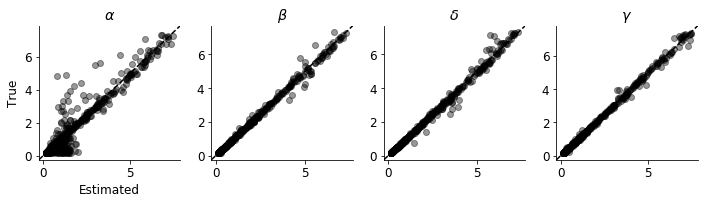

In [72]:
plot_true_est_scatter(model_sumnet, X_test, theta_test, 
                      n_samples_posterior, param_names, figsize=(10, 3), 
                      text=False, filename='LV_rec_sumnet')

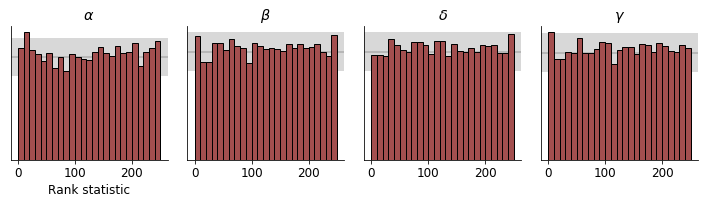

In [71]:
theta_samples = np.concatenate([model_sumnet.sample(x, n_samples=250, to_numpy=True)
                                for x in tf.split(X_sbc, 20, 0)], axis=0)
plot_sbc(theta_samples, theta_sbc, param_names, figsize=(10, 3), bins=25, filename='LV_sbc_sumnet')

## Summary statistics

In [73]:
X_test_s = summarize(X_test.numpy())
X_sbc_s = summarize(X_sbc.numpy())

D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


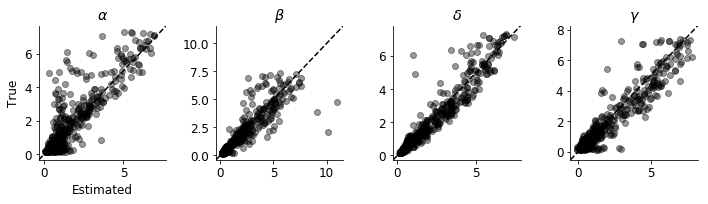

In [74]:
plot_true_est_scatter(model_sumstat, X_test_s, theta_test,
                      n_samples_posterior, param_names, figsize=(10, 3), text=False, filename='LV_rec_sumstat')

C:\Users\Stefan Radev\Desktop\Projects\Paper_cINN\viz.py:400: RuntimeWarning: invalid value encountered in less
  ranks = np.sum(theta_samples < theta_test[:, np.newaxis, :], axis=1)


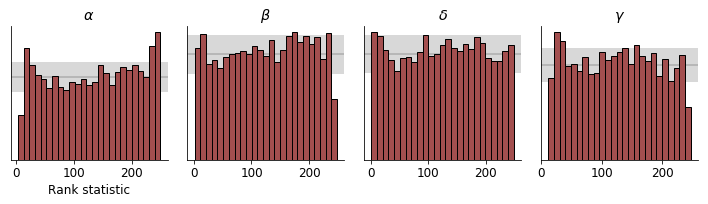

In [75]:
theta_samples = np.concatenate([model_sumstat.sample(x, n_samples=250, to_numpy=True)
                                for x in tf.split(X_sbc_s, 20, 0)], axis=0)
plot_sbc(theta_samples, theta_sbc, param_names, figsize=(10, 3), bins=25, filename='LV_sbc_sumstat')

## Single posterior

In [80]:
theta = np.array([1, 1, 1, 1])
x_test = simulate_lv_params(theta)
x_sum = summarize(x_test.numpy())

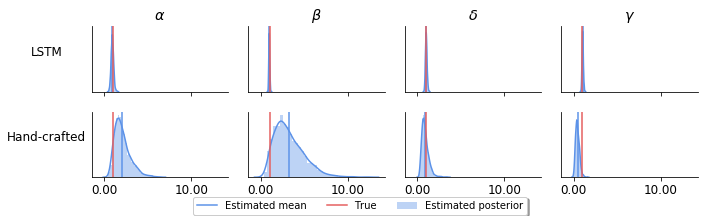

In [86]:
from matplotlib.ticker import FormatStrFormatter

plt.rcParams['font.size'] = 12

# Initialize f
f, axarr = plt.subplots(2, len(param_names), figsize=(10, 3), sharex=True)

theta_samples = model_sumnet.sample(x_test, n_samples_posterior, to_numpy=True)
theta_samples_means = theta_samples.mean(axis=0)

theta_samples_sum = model_sumstat.sample(x_sum, n_samples_posterior, to_numpy=True)
theta_samples_sum_means = theta_samples_sum.mean(axis=0)

# For each row 
for j in range(len(param_names)):

    # Plot approximate posterior with summary network
    sns.distplot(theta_samples[:, j], kde=True, hist=True, ax=axarr[0, j], 
                    label='Estimated posterior', color='#5c92e8')

    # Plot lines for approximate mean, analytic mean and true data-generating value
    axarr[0, j].axvline(theta_samples_means[j], color='#5c92e8', label='Estimated mean')
    axarr[0, j].axvline(theta[j], color='#e55e5e', label='True')
    axarr[0, j].spines['right'].set_visible(False)
    axarr[0, j].spines['top'].set_visible(False)
    axarr[0, j].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axarr[0, j].get_yaxis().set_ticks([])
    axarr[0, j].set_title(param_names[j]) 
    
    
    # Plot approximate posterior with summary statistics
    sns.distplot(theta_samples_sum[:, j], kde=True, hist=True, ax=axarr[1, j], 
                    color='#5c92e8')

    # Plot lines for approximate mean, analytic mean and true data-generating value
    axarr[1, j].axvline(theta_samples_sum_means[j], color='#5c92e8')
    axarr[1, j].axvline(theta[j], color='#e55e5e')
    axarr[1, j].spines['right'].set_visible(False)
    axarr[1, j].spines['top'].set_visible(False)
    axarr[1, j].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axarr[1, j].get_yaxis().set_ticks([]) 
    
    if j == 0:
        f.legend(loc='lower center', bbox_to_anchor=(0.5, -0.04), 
                 shadow=True, ncol=3, fontsize=10, borderaxespad=1)

axarr[0, 0].set_ylabel('LSTM', rotation=0, labelpad=45)
axarr[1, 0].set_ylabel('Hand-crafted', rotation=0, labelpad=45)
f.tight_layout()
f.savefig("figures/LSTM_hand_crafted.png", dpi=300, bbox_inches='tight')